<a href="https://colab.research.google.com/github/zhulkhoirrifat/nuka-pos/blob/main/forecasting_fnb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Library

Langkah pertama adalah mengimpor library yang dibutuhkan untuk proses data dan machine learning.

- `pandas` dan `numpy` untuk manipulasi data
- `matplotlib` dan `seaborn` untuk visualisasi
- `sklearn` untuk preprocessing dan model ML


In [182]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

## Load dan Persiapan Data

Dataset diambil dari file CSV. Setelah itu, dilakukan pengecekan awal seperti:
- Menampilkan 5 data teratas
- Melihat tipe data dan jumlah missing values
- Menampilkan statistik deskriptif
- Menghapus kolom yang tidak relevan
- Mengubah tipe data jika diperlukan

In [183]:
products_df = pd.read_csv('products.csv')
transactions_df = pd.read_csv('transactions.csv')
transaction_details_df = pd.read_csv('transaction_details.csv')
stores_df = pd.read_csv('stores.csv')

In [184]:
transactions_df.columns

Index(['transactionId', 'invoiceId', 'customerId', 'userId', 'storeId',
       'paymentMethodId', 'totalAmount', 'cash', 'change', 'discount',
       'transactionDate', 'status'],
      dtype='object')

In [185]:
transactions_df = transactions_df.rename(columns={'discount': 'discountPerson', 'status': 'statusTransaction' })

In [186]:
transactions_df

,transactionId,invoiceId,customerId,userId,storeId,paymentMethodId,totalAmount,cash,change,discountPerson,transactionDate,statusTransaction
0,1,INV-254458877494,NaN,72,1,3,560558.88,565214.88,4656.0,0,2024-01-02 11:25:07,COMPLETED
1,2,INV-470601977760,3786.0,96,1,3,2186634.24,2187163.24,529.0,0,2024-01-07 10:30:14,COMPLETED
2,3,INV-993764067901,4174.0,72,1,2,3280314.24,3280314.24,0.0,0,2024-01-01 21:29:06,COMPLETED
3,4,INV-639098207995,3826.0,146,1,7,3684522.24,3685947.24,1425.0,0,2024-01-06 21:21:34,COMPLETED
4,5,INV-836595708581,4733.0,146,1,2,1149110.28,1149110.28,0.0,3,2024-01-01 10:19:03,COMPLETED
...,...,...,...,...,...,...,...,...,...,...,...,...
89309,89310,INV-630086877748,NaN,70,30,1,6099027.28,6101775.28,2748.0,10,2025-03-10 09:46:00,COMPLETED
89310,89311,INV-239106088596,NaN,160,30,2,137121.60,137121.60,0.0,0,2025-03-10 09:27:13,COMPLETED
89311,89312,INV-746790987436,NaN,70,30,4,2510026.40,2510085.40,59.0,0,2025-03-11 08:18:52,COMPLETED
89312,89313,INV-628220039782,1587.0,70,30,4,878111.36,882316.36,4205.0,0,2025-03-12 15:40:17,COMPLETED


In [187]:
transaction_details_df.columns

Index(['transactionDetailId', 'transactionId', 'productId', 'variantId',
       'quantity', 'subtotal'],
      dtype='object')

In [188]:
transaction_details_df

,transactionDetailId,transactionId,productId,variantId,quantity,subtotal
0,1,1,1,1,3,500499
1,2,2,2,2,2,1190478
2,3,2,5,5,1,235408
3,4,2,6,6,1,75242
4,5,2,3,3,2,451224
...,...,...,...,...,...,...
267625,267626,89313,311,311,4,784028
267626,267627,89314,315,315,1,28432
267627,267628,89314,305,305,3,470550
267628,267629,89314,313,313,5,955035


In [189]:
products_df.columns

Index(['productId', 'productCode', 'serialNumber', 'categoryId', 'name',
       'description', 'discount', 'basePrice', 'imageUrl', 'isActive',
       'createdAt', 'updatedAt'],
      dtype='object')

In [190]:
products_df = products_df.rename(columns={
    'name': 'productName',
    'description': 'descriptionProduct',
    'discount': 'productDiscount'
})

In [191]:
products_df

,productId,productCode,serialNumber,categoryId,productName,descriptionProduct,productDiscount,basePrice,imageUrl,isActive,createdAt,updatedAt
0,1,PRD-730565,858853.0,27,Moistruizer Consectetur,Labore nulla tempore saepe aut quia nesciunt q...,18,133000,https://placekitten.com/21/644,True,2025-03-06T23:04:21.869675,2025-01-17T19:02:58.287229
1,2,PRD-443514,133692.0,40,Catokan Nostrum,Saepe maxime est assumenda exercitationem sint...,1,563000,https://placekitten.com/656/993,True,2025-03-19T21:36:46.214944,2025-01-21T18:43:23.091461
2,3,PRD-126772,NaN,40,Catokan Facere,In perspiciatis ratione sint itaque soluta cup...,0,187000,https://picsum.photos/585/553,True,2025-02-09T14:05:00.296969,2025-03-14T21:51:10.920836
3,4,PRD-897193,280004.0,28,Sunscreen Wajah Reiciendis,Nam placeat cum accusamus nesciunt praesentium...,0,104000,https://placekitten.com/942/1012,True,2025-03-28T21:21:02.654258,2025-01-14T03:20:10.318053
4,5,PRD-269296,955177.0,36,Parfum Non,Earum inventore dignissimos vel molestiae vita...,0,204000,https://placekitten.com/463/11,True,2025-04-03T01:53:26.003530,2025-04-10T00:55:12.170151
...,...,...,...,...,...,...,...,...,...,...,...,...
311,312,PRD-583648,351536.0,103,Makanan Hewan Peliharaan Nam,Voluptas quis aspernatur fugit ducimus iste an...,0,166000,https://dummyimage.com/115x893,True,2025-04-06T00:11:48.351492,2025-01-12T13:32:47.589411
312,313,PRD-808382,132302.0,103,Makanan Hewan Peliharaan Recusandae,Nobis fugiat repudiandae placeat quod officia ...,0,181000,https://placekitten.com/873/38,True,2025-04-07T02:26:17.874365,2025-01-02T06:56:07.291189
313,314,PRD-412585,451269.0,102,Kandang dan Aksesoris Hewan Qui,Quidem ut aspernatur quisquam necessitatibus n...,19,900000,https://picsum.photos/343/889,True,2025-04-05T21:30:28.402859,2025-02-18T06:53:10.926951
314,315,PRD-476592,308845.0,101,Pakan Ternak At,Deserunt suscipit quod enim tempora architecto...,5,12000,https://picsum.photos/102/697,True,2025-02-19T05:38:08.506213,2025-03-28T05:14:23.561069


In [192]:
stores_df.columns

Index(['storeId', 'StoreCode', 'tenantId', 'name', 'image', 'address',
       'provinceId', 'cityId', 'districtId', 'villageId', 'storeTypeId',
       'postalCode', 'description', 'phoneNumber', 'logo', 'npwpCompany',
       'permitCertificate', 'status'],
      dtype='object')

In [193]:
stores_df = stores_df.rename(columns={
    'name': 'storeName',
    'description': 'storeDescription',
    'status': 'storeStatus'
})

In [194]:
stores_df

,storeId,StoreCode,tenantId,storeName,image,address,provinceId,cityId,districtId,villageId,storeTypeId,postalCode,storeDescription,phoneNumber,logo,npwpCompany,permitCertificate,storeStatus
0,1,STR-274408152573,1,Perawatan Diri & Kecantikan Tarihoran,https://picsum.photos/448/740,"Gg. HOS. Cokroaminoto No. 92\nAmbon, NT 26598",32,71,5579,62967,3,37086,Ea cum culpa dolor debitis. Animi porro in ita...,628189008565,https://dummyimage.com/308x883,https://placekitten.com/416/679,https://placekitten.com/622/73,ACTIVE
1,2,STR-864455930633,1,Makanan & Minuman Tarihoran,https://dummyimage.com/442x269,"Gg. Raya Setiabudhi No. 1\nTanjungpinang, KI 1...",32,71,5507,58912,1,40701,Tenetur accusantium accusamus odit quam. Magni...,628591888614,https://dummyimage.com/181x950,https://picsum.photos/178/215,https://picsum.photos/463/406,ACTIVE
2,3,STR-981272582949,1,Perawatan Diri & Kecantikan Tarihoran Cabang 2,https://picsum.photos/882/140,"Jalan Rumah Sakit No. 2\nSurakarta, Papua Bara...",32,71,5693,61718,3,6673,Rem a laudantium architecto exercitationem err...,628190877113,https://placekitten.com/583/148,https://dummyimage.com/981x824,https://picsum.photos/910/509,ACTIVE
3,4,STR-669558699359,1,Perlengkapan Rumah Tangga & Dekorasi Tarihoran,https://picsum.photos/554/415,"Jl. Pasir Koja No. 864\nTanjungpinang, Maluku ...",32,71,5689,59771,5,47170,Omnis eaque quos. Voluptatibus voluptas in aut...,628199046125,https://placekitten.com/907/633,https://dummyimage.com/468x291,https://placekitten.com/965/442,ACTIVE
4,5,STR-762407648691,2,Peralatan Bayi & Anak Nashiruddin,https://picsum.photos/502/654,"Gang Siliwangi No. 748\nTanjungpinang, SB 50218",32,71,5689,59769,9,68645,Veniam optio consequuntur ut necessitatibus.\n...,628111629391,https://dummyimage.com/192x93,https://picsum.photos/468/944,https://picsum.photos/79/687,ACTIVE
5,6,STR-314119394226,2,Makanan & Minuman Nashiruddin,https://picsum.photos/204/257,"Jl. Waringin No. 274\nKendari, JK 74004",32,71,5783,61366,1,63596,Ipsam odit optio ipsa quo praesentium. Assumen...,628550071393,https://placekitten.com/860/742,https://picsum.photos/675/437,https://placekitten.com/802/981,ACTIVE
6,7,STR-750382527548,3,Peralatan Bayi & Anak Nainggolan,https://dummyimage.com/875x455,"Jl. Kiaracondong No. 4\nSolok, KR 32776",32,71,5579,59139,9,93345,Cupiditate harum facere autem asperiores offic...,628114672534,https://placekitten.com/843/240,https://placekitten.com/762/722,https://picsum.photos/858/571,ACTIVE
7,8,STR-104061397935,3,"Mainan, Hobi & Peralatan Outdoor Nainggolan",https://placekitten.com/155/24,"Jalan Pasteur No. 95\nBalikpapan, Jawa Barat 8...",32,71,5693,60379,8,6436,Fugit distinctio assumenda harum quisquam nequ...,628891293900,https://dummyimage.com/574x589,https://picsum.photos/581/129,https://dummyimage.com/16x575,ACTIVE
8,9,STR-480258745722,3,"Elektronik, Gadget & Alat Musik Nainggolan",https://dummyimage.com/190x613,Gang Indragiri No. 361\nKota Administrasi Jaka...,32,71,5753,60900,4,6660,Pariatur illum laudantium reiciendis. Dolor fu...,628810644630,https://placekitten.com/609/989,https://placekitten.com/550/447,https://placekitten.com/285/821,ACTIVE
9,10,STR-963207851371,3,"Mainan, Hobi & Peralatan Outdoor Nainggolan Ca...",https://dummyimage.com/321x247,"Gg. Rajiman No. 824\nSamarinda, BB 32510",32,71,5753,60195,8,64470,Expedita reprehenderit beatae. Ad ea accusanti...,628514546505,https://picsum.photos/320/971,https://placekitten.com/647/668,https://placekitten.com/197/180,ACTIVE


In [195]:
# menggabungkan dataframe product dan store_fnb
merge_step1 = pd.merge(transactions_df, transaction_details_df, on='transactionId', how='left')
merge_step1

,transactionId,invoiceId,customerId,userId,storeId,paymentMethodId,totalAmount,cash,change,discountPerson,transactionDate,statusTransaction,transactionDetailId,productId,variantId,quantity,subtotal
0,1,INV-254458877494,NaN,72,1,3,560558.88,565214.88,4656.0,0,2024-01-02 11:25:07,COMPLETED,1,1,1,3,500499
1,2,INV-470601977760,3786.0,96,1,3,2186634.24,2187163.24,529.0,0,2024-01-07 10:30:14,COMPLETED,2,2,2,2,1190478
2,2,INV-470601977760,3786.0,96,1,3,2186634.24,2187163.24,529.0,0,2024-01-07 10:30:14,COMPLETED,3,5,5,1,235408
3,2,INV-470601977760,3786.0,96,1,3,2186634.24,2187163.24,529.0,0,2024-01-07 10:30:14,COMPLETED,4,6,6,1,75242
4,2,INV-470601977760,3786.0,96,1,3,2186634.24,2187163.24,529.0,0,2024-01-07 10:30:14,COMPLETED,5,3,3,2,451224
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
267625,89313,INV-628220039782,1587.0,70,30,4,878111.36,882316.36,4205.0,0,2025-03-12 15:40:17,COMPLETED,267626,311,311,4,784028
267626,89314,INV-586130080270,NaN,70,30,6,2287082.56,2290423.56,3341.0,0,2025-03-03 17:04:07,COMPLETED,267627,315,315,1,28432
267627,89314,INV-586130080270,NaN,70,30,6,2287082.56,2290423.56,3341.0,0,2025-03-03 17:04:07,COMPLETED,267628,305,305,3,470550
267628,89314,INV-586130080270,NaN,70,30,6,2287082.56,2290423.56,3341.0,0,2025-03-03 17:04:07,COMPLETED,267629,313,313,5,955035


In [196]:
# menggabungkan dataframe transaction dan products_stores_fnb
merge_step2 = pd.merge(merge_step1, products_df, on='productId', how='left')
merge_step2

,transactionId,invoiceId,customerId,userId,storeId,paymentMethodId,totalAmount,cash,change,discountPerson,transactionDate,statusTransaction,transactionDetailId,productId,variantId,quantity,subtotal,productCode,serialNumber,categoryId,productName,descriptionProduct,productDiscount,basePrice,imageUrl,isActive,createdAt,updatedAt
0,1,INV-254458877494,NaN,72,1,3,560558.88,565214.88,4656.0,0,2024-01-02 11:25:07,COMPLETED,1,1,1,3,500499,PRD-730565,858853.0,27,Moistruizer Consectetur,Labore nulla tempore saepe aut quia nesciunt q...,18,133000,https://placekitten.com/21/644,True,2025-03-06T23:04:21.869675,2025-01-17T19:02:58.287229
1,2,INV-470601977760,3786.0,96,1,3,2186634.24,2187163.24,529.0,0,2024-01-07 10:30:14,COMPLETED,2,2,2,2,1190478,PRD-443514,133692.0,40,Catokan Nostrum,Saepe maxime est assumenda exercitationem sint...,1,563000,https://placekitten.com/656/993,True,2025-03-19T21:36:46.214944,2025-01-21T18:43:23.091461
2,2,INV-470601977760,3786.0,96,1,3,2186634.24,2187163.24,529.0,0,2024-01-07 10:30:14,COMPLETED,3,5,5,1,235408,PRD-269296,955177.0,36,Parfum Non,Earum inventore dignissimos vel molestiae vita...,0,204000,https://placekitten.com/463/11,True,2025-04-03T01:53:26.003530,2025-04-10T00:55:12.170151
3,2,INV-470601977760,3786.0,96,1,3,2186634.24,2187163.24,529.0,0,2024-01-07 10:30:14,COMPLETED,4,6,6,1,75242,PRD-779167,NaN,35,Pomade Ullam,Accusamus quod quia nesciunt fuga itaque moles...,0,49000,https://picsum.photos/432/124,True,2025-02-05T20:06:04.546859,2025-03-11T13:36:02.597779
4,2,INV-470601977760,3786.0,96,1,3,2186634.24,2187163.24,529.0,0,2024-01-07 10:30:14,COMPLETED,5,3,3,2,451224,PRD-126772,NaN,40,Catokan Facere,In perspiciatis ratione sint itaque soluta cup...,0,187000,https://picsum.photos/585/553,True,2025-02-09T14:05:00.296969,2025-03-14T21:51:10.920836
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
267625,89313,INV-628220039782,1587.0,70,30,4,878111.36,882316.36,4205.0,0,2025-03-12 15:40:17,COMPLETED,267626,311,311,4,784028,PRD-859014,NaN,103,Makanan Hewan Peliharaan Occaecati,Delectus aut nulla deserunt ut corporis.,0,186000,https://dummyimage.com/555x470,True,2025-01-01T12:48:45.446591,2025-01-03T20:45:25.231429
267626,89314,INV-586130080270,NaN,70,30,6,2287082.56,2290423.56,3341.0,0,2025-03-03 17:04:07,COMPLETED,267627,315,315,1,28432,PRD-476592,308845.0,101,Pakan Ternak At,Deserunt suscipit quod enim tempora architecto...,5,12000,https://picsum.photos/102/697,True,2025-02-19T05:38:08.506213,2025-03-28T05:14:23.561069
267627,89314,INV-586130080270,NaN,70,30,6,2287082.56,2290423.56,3341.0,0,2025-03-03 17:04:07,COMPLETED,267628,305,305,3,470550,PRD-955271,871686.0,103,Makanan Hewan Peliharaan Atque,Incidunt occaecati eos voluptatibus eaque culp...,0,110000,https://picsum.photos/926/840,True,2025-04-05T06:17:58.179626,2025-01-03T18:14:48.020152
267628,89314,INV-586130080270,NaN,70,30,6,2287082.56,2290423.56,3341.0,0,2025-03-03 17:04:07,COMPLETED,267629,313,313,5,955035,PRD-808382,132302.0,103,Makanan Hewan Peliharaan Recusandae,Nobis fugiat repudiandae placeat quod officia ...,0,181000,https://placekitten.com/873/38,True,2025-04-07T02:26:17.874365,2025-01-02T06:56:07.291189


In [197]:
final_df = pd.merge(merge_step2, stores_df, on='storeId', how='left')
final_df

,transactionId,invoiceId,customerId,userId,storeId,paymentMethodId,totalAmount,cash,change,discountPerson,transactionDate,statusTransaction,transactionDetailId,productId,variantId,quantity,subtotal,productCode,serialNumber,categoryId,productName,descriptionProduct,productDiscount,basePrice,imageUrl,isActive,createdAt,updatedAt,StoreCode,tenantId,storeName,image,address,provinceId,cityId,districtId,villageId,storeTypeId,postalCode,storeDescription,phoneNumber,logo,npwpCompany,permitCertificate,storeStatus
0,1,INV-254458877494,NaN,72,1,3,560558.88,565214.88,4656.0,0,2024-01-02 11:25:07,COMPLETED,1,1,1,3,500499,PRD-730565,858853.0,27,Moistruizer Consectetur,Labore nulla tempore saepe aut quia nesciunt q...,18,133000,https://placekitten.com/21/644,True,2025-03-06T23:04:21.869675,2025-01-17T19:02:58.287229,STR-274408152573,1,Perawatan Diri & Kecantikan Tarihoran,https://picsum.photos/448/740,"Gg. HOS. Cokroaminoto No. 92\nAmbon, NT 26598",32,71,5579,62967,3,37086,Ea cum culpa dolor debitis. Animi porro in ita...,628189008565,https://dummyimage.com/308x883,https://placekitten.com/416/679,https://placekitten.com/622/73,ACTIVE
1,2,INV-470601977760,3786.0,96,1,3,2186634.24,2187163.24,529.0,0,2024-01-07 10:30:14,COMPLETED,2,2,2,2,1190478,PRD-443514,133692.0,40,Catokan Nostrum,Saepe maxime est assumenda exercitationem sint...,1,563000,https://placekitten.com/656/993,True,2025-03-19T21:36:46.214944,2025-01-21T18:43:23.091461,STR-274408152573,1,Perawatan Diri & Kecantikan Tarihoran,https://picsum.photos/448/740,"Gg. HOS. Cokroaminoto No. 92\nAmbon, NT 26598",32,71,5579,62967,3,37086,Ea cum culpa dolor debitis. Animi porro in ita...,628189008565,https://dummyimage.com/308x883,https://placekitten.com/416/679,https://placekitten.com/622/73,ACTIVE
2,2,INV-470601977760,3786.0,96,1,3,2186634.24,2187163.24,529.0,0,2024-01-07 10:30:14,COMPLETED,3,5,5,1,235408,PRD-269296,955177.0,36,Parfum Non,Earum inventore dignissimos vel molestiae vita...,0,204000,https://placekitten.com/463/11,True,2025-04-03T01:53:26.003530,2025-04-10T00:55:12.170151,STR-274408152573,1,Perawatan Diri & Kecantikan Tarihoran,https://picsum.photos/448/740,"Gg. HOS. Cokroaminoto No. 92\nAmbon, NT 26598",32,71,5579,62967,3,37086,Ea cum culpa dolor debitis. Animi porro in ita...,628189008565,https://dummyimage.com/308x883,https://placekitten.com/416/679,https://placekitten.com/622/73,ACTIVE
3,2,INV-470601977760,3786.0,96,1,3,2186634.24,2187163.24,529.0,0,2024-01-07 10:30:14,COMPLETED,4,6,6,1,75242,PRD-779167,NaN,35,Pomade Ullam,Accusamus quod quia nesciunt fuga itaque moles...,0,49000,https://picsum.photos/432/124,True,2025-02-05T20:06:04.546859,2025-03-11T13:36:02.597779,STR-274408152573,1,Perawatan Diri & Kecantikan Tarihoran,https://picsum.photos/448/740,"Gg. HOS. Cokroaminoto No. 92\nAmbon, NT 26598",32,71,5579,62967,3,37086,Ea cum culpa dolor debitis. Animi porro in ita...,628189008565,https://dummyimage.com/308x883,https://placekitten.com/416/679,https://placekitten.com/622/73,ACTIVE
4,2,INV-470601977760,3786.0,96,1,3,2186634.24,2187163.24,529.0,0,2024-01-07 10:30:14,COMPLETED,5,3,3,2,451224,PRD-126772,NaN,40,Catokan Facere,In perspiciatis ratione sint itaque soluta cup...,0,187000,https://picsum.photos/585/553,True,2025-02-09T14:05:00.296969,2025-03-14T21:51:10.920836,STR-274408152573,1,Perawatan Diri & Kecantikan Tarihoran,https://picsum.photos/448/740,"Gg. HOS. Cokroaminoto No. 92\nAmbon, NT 26598",32,71,5579,62967,3,37086,Ea cum culpa dolor debitis. Animi porro in ita...,628189008565,https://dummyimage.com/308x883,https://placekitten.com/416/679,https://placekitten.com/622/73,ACTIVE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
267625,89313,INV-628220039782,1587.0,70,30,4,878111.36,882316.36,4205.0,0,2025-03-12 15:40:17,COMPLETED,267626,311,311,4,784028,PRD-859014,NaN,103,Makanan Hewan Peliharaan Occaecati,Delectus aut nulla deserunt ut

In [198]:
final_df.columns

Index(['transactionId', 'invoiceId', 'customerId', 'userId', 'storeId',
       'paymentMethodId', 'totalAmount', 'cash', 'change', 'discountPerson',
       'transactionDate', 'statusTransaction', 'transactionDetailId',
       'productId', 'variantId', 'quantity', 'subtotal', 'productCode',
       'serialNumber', 'categoryId', 'productName', 'descriptionProduct',
       'productDiscount', 'basePrice', 'imageUrl', 'isActive', 'createdAt',
       'updatedAt', 'StoreCode', 'tenantId', 'storeName', 'image', 'address',
       'provinceId', 'cityId', 'districtId', 'villageId', 'storeTypeId',
       'postalCode', 'storeDescription', 'phoneNumber', 'logo', 'npwpCompany',
       'permitCertificate', 'storeStatus'],
      dtype='object')

In [199]:
#mengambil data toko dengan tipe toko id 1 yaitu fnb
final_df = final_df[final_df['storeTypeId'] == 10]
final_df

,transactionId,invoiceId,customerId,userId,storeId,paymentMethodId,totalAmount,cash,change,discountPerson,transactionDate,statusTransaction,transactionDetailId,productId,variantId,quantity,subtotal,productCode,serialNumber,categoryId,productName,descriptionProduct,productDiscount,basePrice,imageUrl,isActive,createdAt,updatedAt,StoreCode,tenantId,storeName,image,address,provinceId,cityId,districtId,villageId,storeTypeId,postalCode,storeDescription,phoneNumber,logo,npwpCompany,permitCertificate,storeStatus
111773,37309,INV-141196780560,2205.0,144,16,5,486433.92,489176.92,2743.0,0,2024-01-07 12:42:43,COMPLETED,111774,160,160,3,73971,PRD-350944,768793.0,70,Rokok Corporis,Illo sit eos iusto id asperiores.,0,14000,https://dummyimage.com/977x403,True,2025-03-27T15:23:40.738707,2025-01-16T08:03:51.920901,STR-149548347757,5,Minimarket & Kelontong Gunawan,https://placekitten.com/596/891,"Gang Tebet Barat Dalam No. 99\nSukabumi, Jawa ...",32,71,5783,61365,10,35944,Maiores cumque alias nam voluptatem. Ratione m...,628881612482,https://picsum.photos/490/151,https://dummyimage.com/531x175,https://placekitten.com/750/385,ACTIVE
111774,37309,INV-141196780560,2205.0,144,16,5,486433.92,489176.92,2743.0,0,2024-01-07 12:42:43,COMPLETED,111775,154,154,2,242490,PRD-926335,NaN,74,Alat Tulis Kantor Exercitationem,Accusamus doloribus quae occaecati magnam libe...,6,78000,https://dummyimage.com/335x605,True,2025-02-18T14:23:58.555480,2025-01-03T04:15:20.864428,STR-149548347757,5,Minimarket & Kelontong Gunawan,https://placekitten.com/596/891,"Gang Tebet Barat Dalam No. 99\nSukabumi, Jawa ...",32,71,5783,61365,10,35944,Maiores cumque alias nam voluptatem. Ratione m...,628881612482,https://picsum.photos/490/151,https://dummyimage.com/531x175,https://placekitten.com/750/385,ACTIVE
111775,37309,INV-141196780560,2205.0,144,16,5,486433.92,489176.92,2743.0,0,2024-01-07 12:42:43,COMPLETED,111776,159,159,3,117855,PRD-112350,463889.0,70,Rokok Quibusdam,Natus asperiores sit ut voluptatem libero quib...,0,24000,https://dummyimage.com/617x481,True,2025-04-07T16:07:54.739870,2025-02-21T17:17:25.512967,STR-149548347757,5,Minimarket & Kelontong Gunawan,https://placekitten.com/596/891,"Gang Tebet Barat Dalam No. 99\nSukabumi, Jawa ...",32,71,5783,61365,10,35944,Maiores cumque alias nam voluptatem. Ratione m...,628881612482,https://picsum.photos/490/151,https://dummyimage.com/531x175,https://placekitten.com/750/385,ACTIVE
111776,37310,INV-339072024356,4576.0,94,16,1,33919.20,35460.20,1541.0,0,2024-01-07 16:27:50,COMPLETED,111777,153,153,1,30285,PRD-631621,477170.0,70,Rokok Expedita,Mollitia perspiciatis ex dicta laboriosam dolo...,0,15000,https://dummyimage.com/729x1005,True,2025-01-27T09:49:13.921020,2025-02-14T16:47:54.817693,STR-149548347757,5,Minimarket & Kelontong Gunawan,https://placekitten.com/596/891,"Gang Tebet Barat Dalam No. 99\nSukabumi, Jawa ...",32,71,5783,61365,10,35944,Maiores cumque alias nam voluptatem. Ratione m...,628881612482,https://picsum.photos/490/151,https://dummyimage.com/531x175,https://placekitten.com/750/385,ACTIVE
111777,37311,INV-400477904222,NaN,139,16,4,376984.16,379163.16,2179.0,0,2024-01-03 09:00:12,COMPLETED,111778,161,161,1,75285,PRD-198421,795196.0,74,Alat Tulis Kantor Dolorem,Corporis asperiores delectus facere eos error ...,0,60000,https://dummyimage.com/1006x891,True,2025-01-10T09:55:49.968197,2025-01-19T13:31:25.874544,STR-149548347757,5,Minimarket & Kelontong Gunawan,https://placekitten.com/596/891,"Gang Tebet Barat Dalam No. 99\nSukabumi, Jawa ...",32,71,5783,61365,10,35944,Maiores cumque alias nam voluptatem. Ratione m...,628881612482,https://picsum.photos/490/151,https://dummyimage.com/531x175,https://placekitten.com/750/385,ACTIVE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167025,55732,INV-662502382633,4149.0,94,16,7,497021.28,499501.28,2480.0,0,2024-01-25 10:33:40,COMPLETED,167026,152

In [ ]:
final_df.columns

Index(['transactionId', 'invoiceId', 'customerId', 'userId', 'storeId',
       'paymentMethodId', 'totalAmount', 'cash', 'change', 'discountPerson',
       'transactionDate', 'statusTransaction', 'transactionDetailId',
       'productId', 'variantId', 'quantity', 'subtotal', 'productCode',
       'serialNumber', 'categoryId', 'productName', 'descriptionProduct',
       'productDiscount', 'basePrice', 'imageUrl', 'isActive', 'createdAt',
       'updatedAt', 'StoreCode', 'tenantId', 'storeName', 'image', 'address',
       'provinceId', 'cityId', 'districtId', 'villageId', 'storeTypeId',
       'postalCode', 'storeDescription', 'phoneNumber', 'logo', 'npwpCompany',
       'permitCertificate', 'storeStatus'],
      dtype='object')

In [200]:
selected_columns = [
    'transactionDate', 'quantity', 'productId', 'storeId', 'categoryId',
    'basePrice', 'productDiscount', 'discountPerson', 'totalAmount'
]

final_df = final_df[selected_columns]
final_df

,transactionDate,quantity,productId,storeId,categoryId,basePrice,productDiscount,discountPerson,totalAmount
111773,2024-01-07 12:42:43,3,160,16,70,14000,0,0,486433.92
111774,2024-01-07 12:42:43,2,154,16,74,78000,6,0,486433.92
111775,2024-01-07 12:42:43,3,159,16,70,24000,0,0,486433.92
111776,2024-01-07 16:27:50,1,153,16,70,15000,0,0,33919.20
111777,2024-01-03 09:00:12,1,161,16,74,60000,0,0,376984.16
...,...,...,...,...,...,...,...,...,...
167025,2024-01-25 10:33:40,3,152,16,67,57000,0,0,497021.28
167026,2024-01-25 15:08:15,3,159,16,70,24000,0,0,724009.44
167027,2024-01-25 15:08:15,5,157,16,73,21000,0,0,724009.44
167028,2024-01-25 15:08:15,4,160,16,70,14000,0,0,724009.44


In [201]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 55257 entries, 111773 to 167029
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   transactionDate  55257 non-null  object 
 1   quantity         55257 non-null  int64  
 2   productId        55257 non-null  int64  
 3   storeId          55257 non-null  int64  
 4   categoryId       55257 non-null  int64  
 5   basePrice        55257 non-null  int64  
 6   productDiscount  55257 non-null  int64  
 7   discountPerson   55257 non-null  int64  
 8   totalAmount      55257 non-null  float64
dtypes: float64(1), int64(7), object(1)
memory usage: 6.2+ MB


In [202]:
final_df['transactionDate'] = pd.to_datetime(final_df['transactionDate'])

<ipython-input-202-0ea110b0c623>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['transactionDate'] = pd.to_datetime(final_df['transactionDate'])


In [203]:
final_df.describe()

,transactionDate,quantity,productId,storeId,categoryId,basePrice,productDiscount,discountPerson,totalAmount
count,55257,55257.000000,55257.000000,55257.0,55257.000000,55257.000000,55257.000000,55257.000000,5.525700e+04
mean,2024-08-02 13:52:48.201495040,3.001321,154.001810,16.0,70.926941,37186.691279,1.858660,0.968637,7.535303e+05
min,2024-01-01 09:03:27,1.000000,147.000000,16.0,67.000000,4000.000000,0.000000,0.000000,1.160992e+04
25%,2024-04-13 12:53:18,2.000000,150.000000,16.0,68.000000,15000.000000,0.000000,0.000000,4.836563e+05
50%,2024-08-02 09:26:10,3.000000,154.000000,16.0,70.000000,35000.000000,0.000000,0.000000,7.412854e+05
75%,2024-11-23 13:08:40,4.000000,158.000000,16.0,74.000000,60000.000000,0.000000,0.000000,1.004936e+06
max,2025-03-15 17:57:45,5.000000,161.000000,16.0,74.000000,78000.000000,13.000000,20.000000,2.321004e+06
std,NaN,1.413861,4.319414,0.0,2.645731,23563.900048,3.938774,3.508332,3.634498e+05


## Feature Engineering

Tahapan ini digunakan untuk menambahkan, mengubah, atau menggabungkan fitur agar model bisa belajar lebih baik.

- Fitur berbasis waktu
- Fitur berbasis harga
- Fitur berbasis produk
- Fitur berbasis toko
- Fitur agregasi historis


In [204]:
final_df['hour'] = final_df['transactionDate'].dt.hour
final_df['dayOfWeek'] = final_df['transactionDate'].dt.day_name()
final_df['month'] = final_df['transactionDate'].dt.month
final_df['isWeekend'] = final_df['transactionDate'].dt.dayofweek >= 5

final_df

<ipython-input-204-9aa93b287f66>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['hour'] = final_df['transactionDate'].dt.hour
<ipython-input-204-9aa93b287f66>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['dayOfWeek'] = final_df['transactionDate'].dt.day_name()
<ipython-input-204-9aa93b287f66>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

,transactionDate,quantity,productId,storeId,categoryId,basePrice,productDiscount,discountPerson,totalAmount,hour,dayOfWeek,month,isWeekend
111773,2024-01-07 12:42:43,3,160,16,70,14000,0,0,486433.92,12,Sunday,1,True
111774,2024-01-07 12:42:43,2,154,16,74,78000,6,0,486433.92,12,Sunday,1,True
111775,2024-01-07 12:42:43,3,159,16,70,24000,0,0,486433.92,12,Sunday,1,True
111776,2024-01-07 16:27:50,1,153,16,70,15000,0,0,33919.20,16,Sunday,1,True
111777,2024-01-03 09:00:12,1,161,16,74,60000,0,0,376984.16,9,Wednesday,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
167025,2024-01-25 10:33:40,3,152,16,67,57000,0,0,497021.28,10,Thursday,1,False
167026,2024-01-25 15:08:15,3,159,16,70,24000,0,0,724009.44,15,Thursday,1,False
167027,2024-01-25 15:08:15,5,157,16,73,21000,0,0,724009.44,15,Thursday,1,False
167028,2024-01-25 15:08:15,4,160,16,70,14000,0,0,724009.44,15,Thursday,1,False


In [205]:
final_df['dayOfWeek'].value_counts()

,count
dayOfWeek,
Sunday,10612
Saturday,10327
Friday,8429
Monday,6715
Wednesday,6516
Thursday,6389
Tuesday,6269


In [206]:
tax_rate = 0.11
final_df['effectivePrice'] = final_df['basePrice'] * (1 - final_df['productDiscount'] / 100)
final_df['effectivePriceWithTax'] = final_df['effectivePrice'] * (1 + tax_rate)
final_df['finalPricePerUnit'] = final_df['effectivePriceWithTax'] - (final_df['discountPerson'] / final_df['quantity'])

<ipython-input-206-34b35fcb6528>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['effectivePrice'] = final_df['basePrice'] * (1 - final_df['productDiscount'] / 100)
<ipython-input-206-34b35fcb6528>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['effectivePriceWithTax'] = final_df['effectivePrice'] * (1 + tax_rate)
<ipython-input-206-34b35fcb6528>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

In [207]:
final_df['total_quantity_product'] = final_df.groupby('productId')['quantity'].transform('sum')
final_df['avg_sales_product'] = final_df.groupby('productId')['totalAmount'].transform('mean')

# final_df

<ipython-input-207-807bd9a9f09e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['total_quantity_product'] = final_df.groupby('productId')['quantity'].transform('sum')
<ipython-input-207-807bd9a9f09e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['avg_sales_product'] = final_df.groupby('productId')['totalAmount'].transform('mean')


In [208]:
final_df['rollingAvg7d'] = final_df.groupby('productId')['totalAmount'].rolling(window=7).mean().reset_index(level=0, drop=True)
final_df

<ipython-input-208-08e6f3e6e494>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['rollingAvg7d'] = final_df.groupby('productId')['totalAmount'].rolling(window=7).mean().reset_index(level=0, drop=True)


,transactionDate,quantity,productId,storeId,categoryId,basePrice,productDiscount,discountPerson,totalAmount,hour,dayOfWeek,month,isWeekend,effectivePrice,effectivePriceWithTax,finalPricePerUnit,total_quantity_product,avg_sales_product,rollingAvg7d
111773,2024-01-07 12:42:43,3,160,16,70,14000,0,0,486433.92,12,Sunday,1,True,14000.0,15540.0,15540.0,10993,690749.826082,NaN
111774,2024-01-07 12:42:43,2,154,16,74,78000,6,0,486433.92,12,Sunday,1,True,73320.0,81385.2,81385.2,11125,863852.380973,NaN
111775,2024-01-07 12:42:43,3,159,16,70,24000,0,0,486433.92,12,Sunday,1,True,24000.0,26640.0,26640.0,11114,716527.892037,NaN
111776,2024-01-07 16:27:50,1,153,16,70,15000,0,0,33919.20,16,Sunday,1,True,15000.0,16650.0,16650.0,10871,691698.583573,NaN
111777,2024-01-03 09:00:12,1,161,16,74,60000,0,0,376984.16,9,Wednesday,1,False,60000.0,66600.0,66600.0,10952,805948.411865,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167025,2024-01-25 10:33:40,3,152,16,67,57000,0,0,497021.28,10,Thursday,1,False,57000.0,63270.0,63270.0,10900,806698.553210,707077.960000
167026,2024-01-25 15:08:15,3,159,16,70,24000,0,0,724009.44,15,Thursday,1,False,24000.0,26640.0,26640.0,11114,716527.892037,746444.914286
167027,2024-01-25 15:08:15,5,157,16,73,21000,0,0,724009.44,15,Thursday,1,False,21000.0,23310.0,23310.0,11257,721727.362269,563757.280000
167028,2024-01-25 15:08:15,4,160,16,70,14000,0,0,724009.44,15,Thursday,1,False,14000.0,15540.0,15540.0,10993,690749.826082,780221.022857


In [209]:
le = LabelEncoder()
final_df['dayOfWeek'] = le.fit_transform(final_df['dayOfWeek'])
final_df

<ipython-input-209-bb47f653789e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['dayOfWeek'] = le.fit_transform(final_df['dayOfWeek'])


,transactionDate,quantity,productId,storeId,categoryId,basePrice,productDiscount,discountPerson,totalAmount,hour,dayOfWeek,month,isWeekend,effectivePrice,effectivePriceWithTax,finalPricePerUnit,total_quantity_product,avg_sales_product,rollingAvg7d
111773,2024-01-07 12:42:43,3,160,16,70,14000,0,0,486433.92,12,3,1,True,14000.0,15540.0,15540.0,10993,690749.826082,NaN
111774,2024-01-07 12:42:43,2,154,16,74,78000,6,0,486433.92,12,3,1,True,73320.0,81385.2,81385.2,11125,863852.380973,NaN
111775,2024-01-07 12:42:43,3,159,16,70,24000,0,0,486433.92,12,3,1,True,24000.0,26640.0,26640.0,11114,716527.892037,NaN
111776,2024-01-07 16:27:50,1,153,16,70,15000,0,0,33919.20,16,3,1,True,15000.0,16650.0,16650.0,10871,691698.583573,NaN
111777,2024-01-03 09:00:12,1,161,16,74,60000,0,0,376984.16,9,6,1,False,60000.0,66600.0,66600.0,10952,805948.411865,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167025,2024-01-25 10:33:40,3,152,16,67,57000,0,0,497021.28,10,4,1,False,57000.0,63270.0,63270.0,10900,806698.553210,707077.960000
167026,2024-01-25 15:08:15,3,159,16,70,24000,0,0,724009.44,15,4,1,False,24000.0,26640.0,26640.0,11114,716527.892037,746444.914286
167027,2024-01-25 15:08:15,5,157,16,73,21000,0,0,724009.44,15,4,1,False,21000.0,23310.0,23310.0,11257,721727.362269,563757.280000
167028,2024-01-25 15:08:15,4,160,16,70,14000,0,0,724009.44,15,4,1,False,14000.0,15540.0,15540.0,10993,690749.826082,780221.022857


In [210]:
final_backup_df = final_df.copy()
final_df.drop(['transactionDate', 'dayOfWeek'], axis=1)

,quantity,productId,storeId,categoryId,basePrice,productDiscount,discountPerson,totalAmount,hour,month,isWeekend,effectivePrice,effectivePriceWithTax,finalPricePerUnit,total_quantity_product,avg_sales_product,rollingAvg7d
111773,3,160,16,70,14000,0,0,486433.92,12,1,True,14000.0,15540.0,15540.0,10993,690749.826082,NaN
111774,2,154,16,74,78000,6,0,486433.92,12,1,True,73320.0,81385.2,81385.2,11125,863852.380973,NaN
111775,3,159,16,70,24000,0,0,486433.92,12,1,True,24000.0,26640.0,26640.0,11114,716527.892037,NaN
111776,1,153,16,70,15000,0,0,33919.20,16,1,True,15000.0,16650.0,16650.0,10871,691698.583573,NaN
111777,1,161,16,74,60000,0,0,376984.16,9,1,False,60000.0,66600.0,66600.0,10952,805948.411865,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167025,3,152,16,67,57000,0,0,497021.28,10,1,False,57000.0,63270.0,63270.0,10900,806698.553210,707077.960000
167026,3,159,16,70,24000,0,0,724009.44,15,1,False,24000.0,26640.0,26640.0,11114,716527.892037,746444.914286
167027,5,157,16,73,21000,0,0,724009.44,15,1,False,21000.0,23310.0,23310.0,11257,721727.362269,563757.280000
167028,4,160,16,70,14000,0,0,724009.44,15,1,False,14000.0,15540.0,15540.0,10993,690749.826082,780221.022857


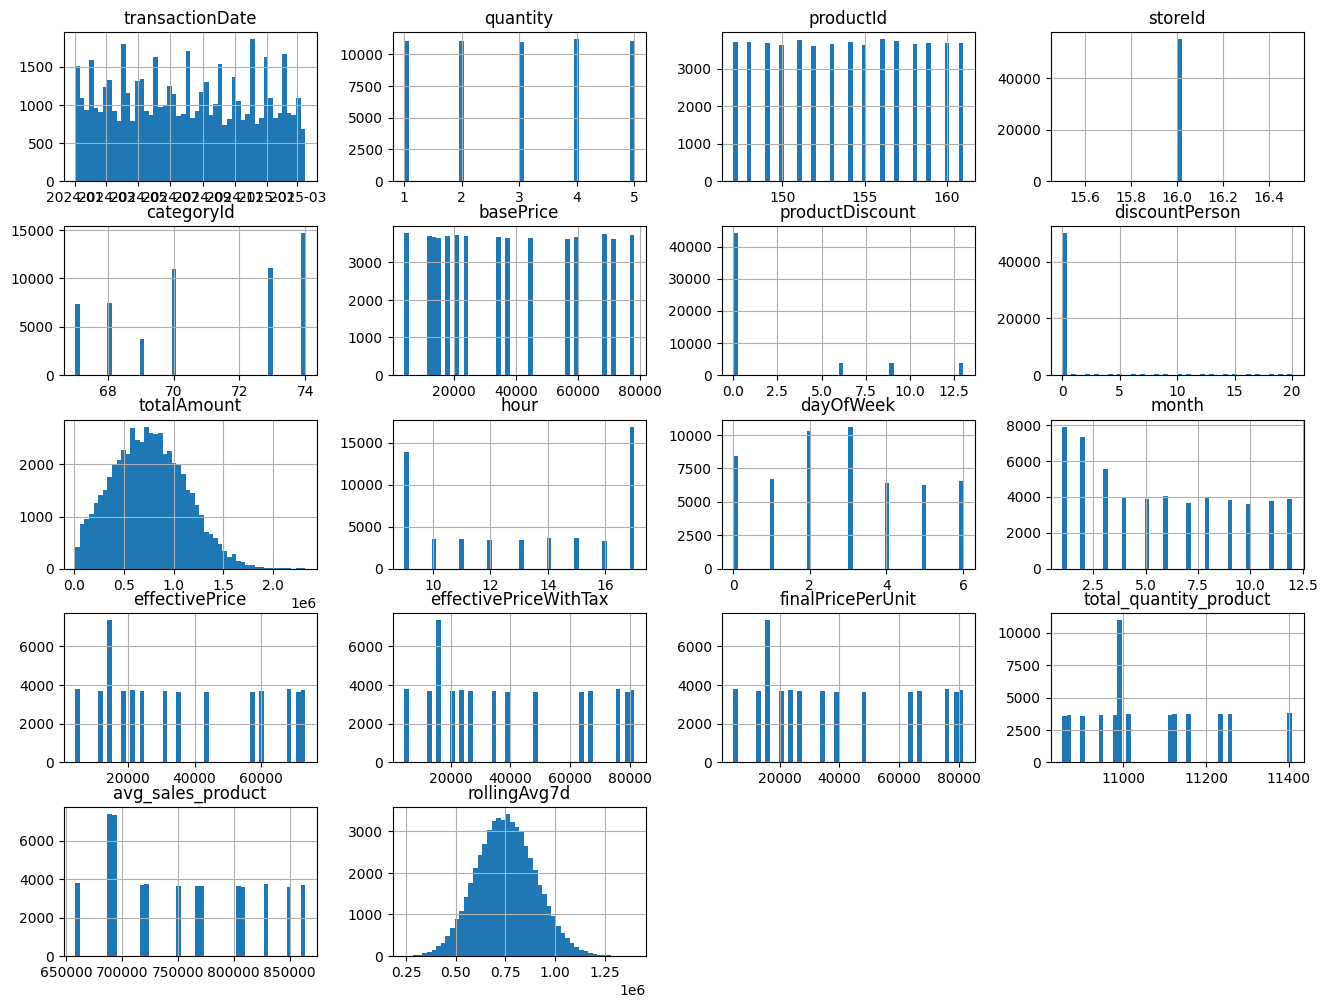

In [211]:
final_df.hist(bins=50, figsize=(16, 12))
plt.show()

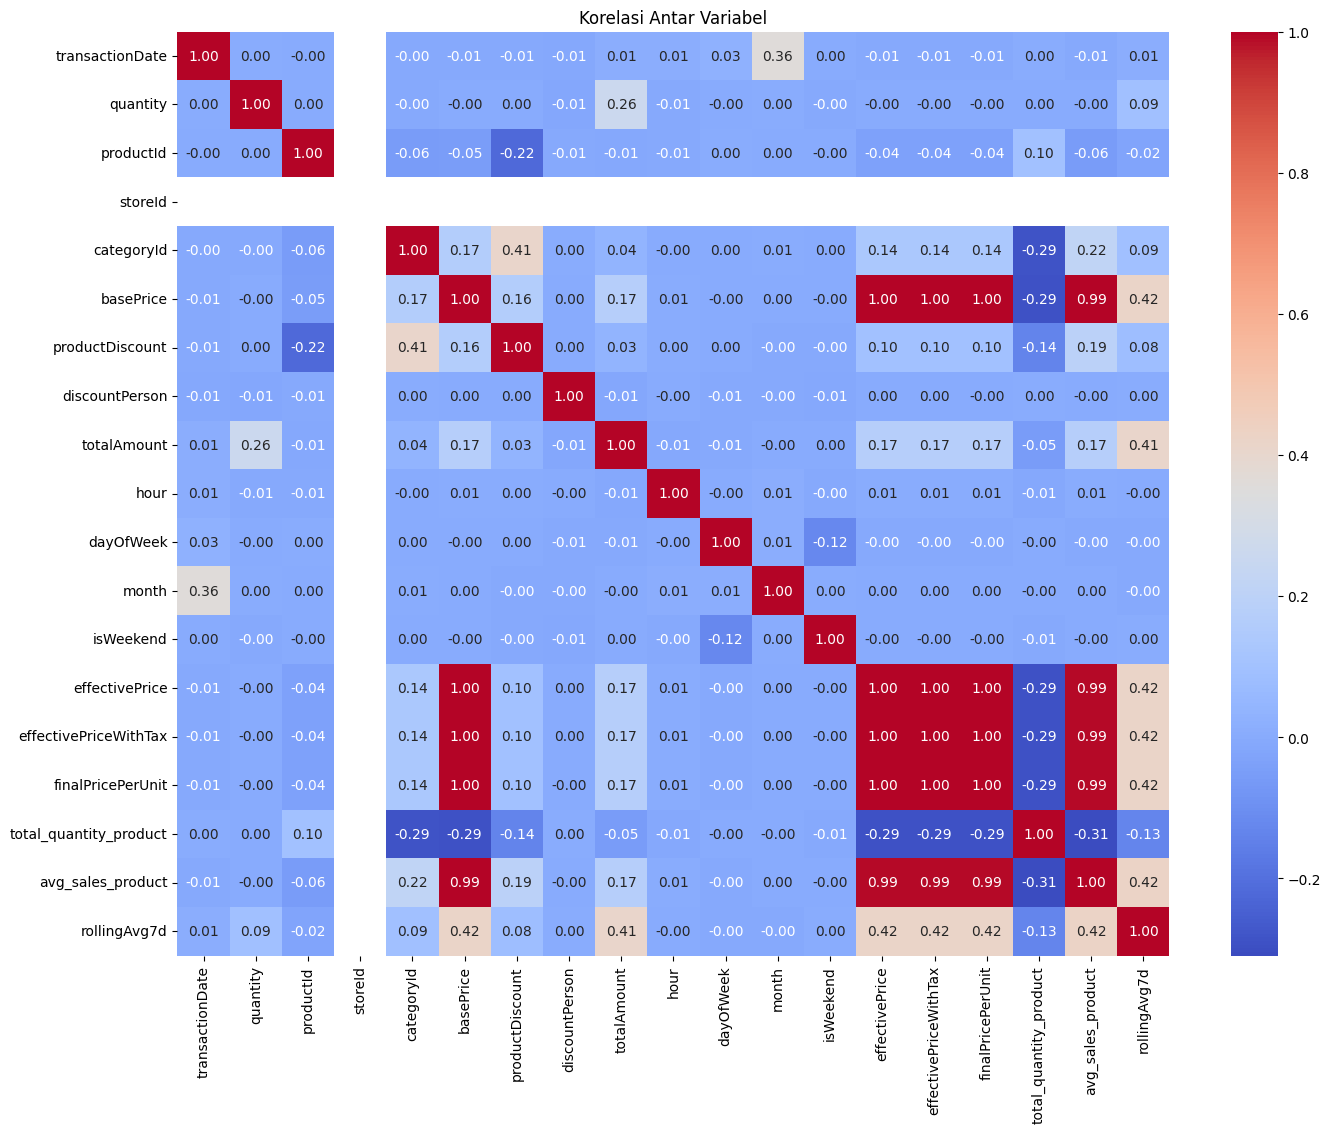

In [212]:
corr_matrix = final_df.corr()

plt.figure(figsize=(16, 12))

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')

plt.title('Korelasi Antar Variabel')

plt.show()

## Data Pre-processing

In [213]:
copy_df = final_df.copy()
copy_df = copy_df.dropna()
copy_df_with_date = copy_df.copy()

In [214]:
copy_df_with_date['transactionDate'] = final_df['transactionDate']
copy_df_with_date = copy_df_with_date.sort_values('transactionDate')
last_date = copy_df_with_date['transactionDate'].max()
cutoff_date = last_date - pd.Timedelta(days=30)

In [215]:
train_df = copy_df_with_date[copy_df_with_date['transactionDate'] < cutoff_date]
test_df = copy_df_with_date[copy_df_with_date['transactionDate'] >= cutoff_date]

In [216]:
selected_columns = ['quantity', 'basePrice', 'productDiscount', 'hour', 'isWeekend',
                   'effectivePrice', 'effectivePriceWithTax', 'finalPricePerUnit', 'rollingAvg7d',
                    'total_quantity_product', 'avg_sales_product']

X_train = train_df[selected_columns]
y_train = train_df['totalAmount']
X_test = test_df[selected_columns]
y_test = test_df['totalAmount']

In [217]:
scaler = StandardScaler()
features = ['quantity', 'basePrice', 'productDiscount', 'hour',
            'effectivePrice', 'effectivePriceWithTax', 'finalPricePerUnit',
            'rollingAvg7d', 'total_quantity_product', 'avg_sales_product']

scaler.fit(X_train[features])
X_train[features] = scaler.transform(X_train[features])
X_test[features] = scaler.transform(X_test[features])

<ipython-input-217-dd815c3735a2>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[features] = scaler.transform(X_train[features])
<ipython-input-217-dd815c3735a2>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[features] = scaler.transform(X_test[features])


## Modeling

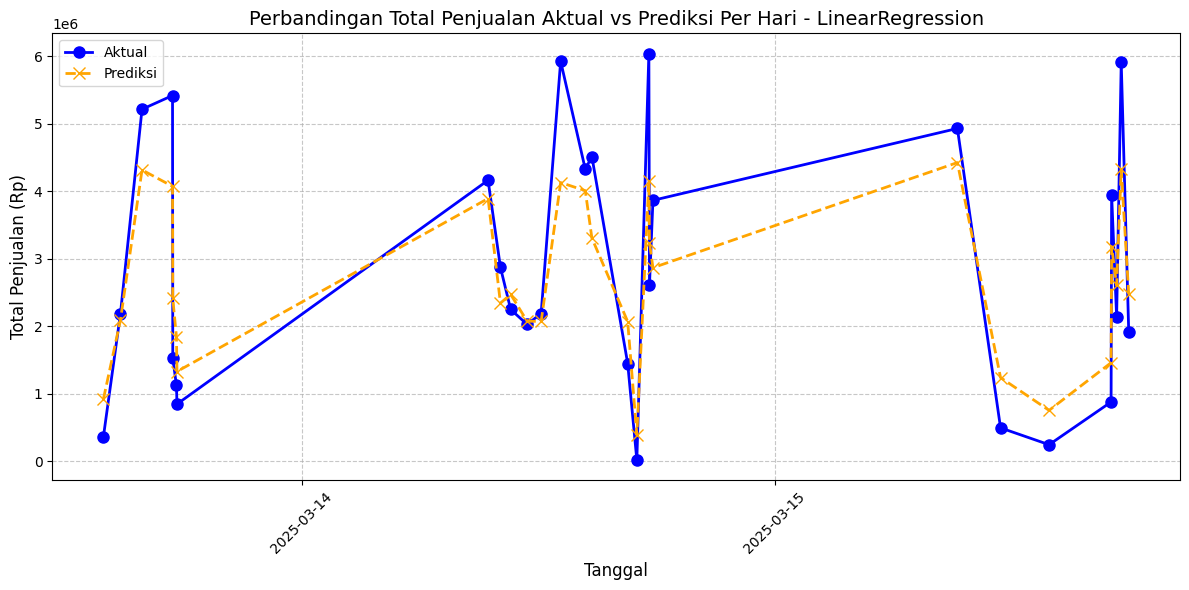

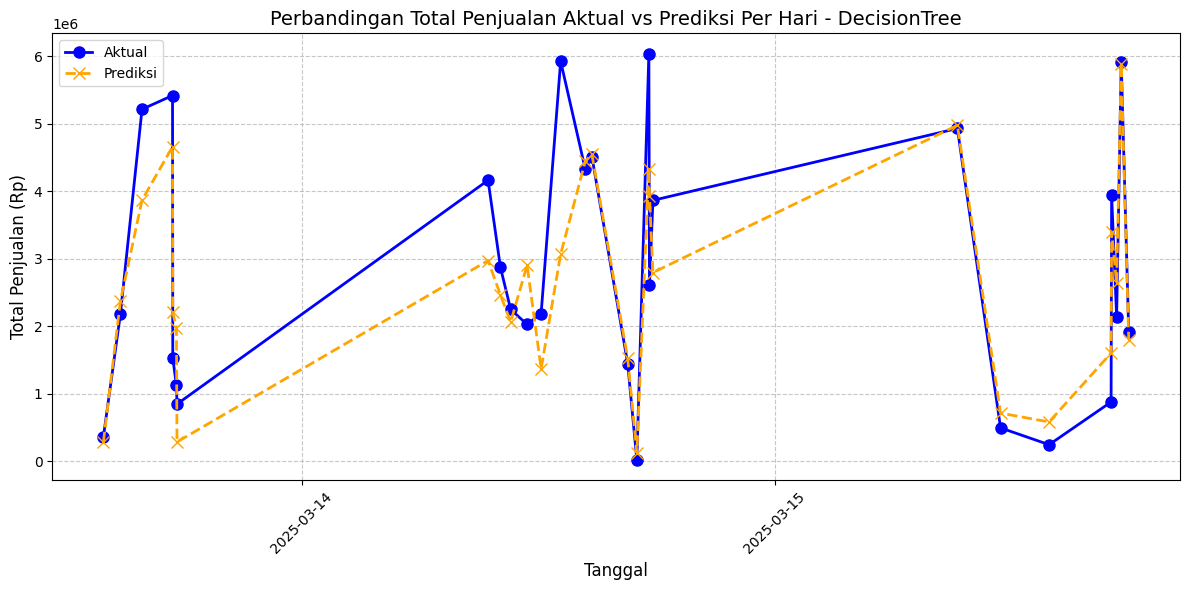

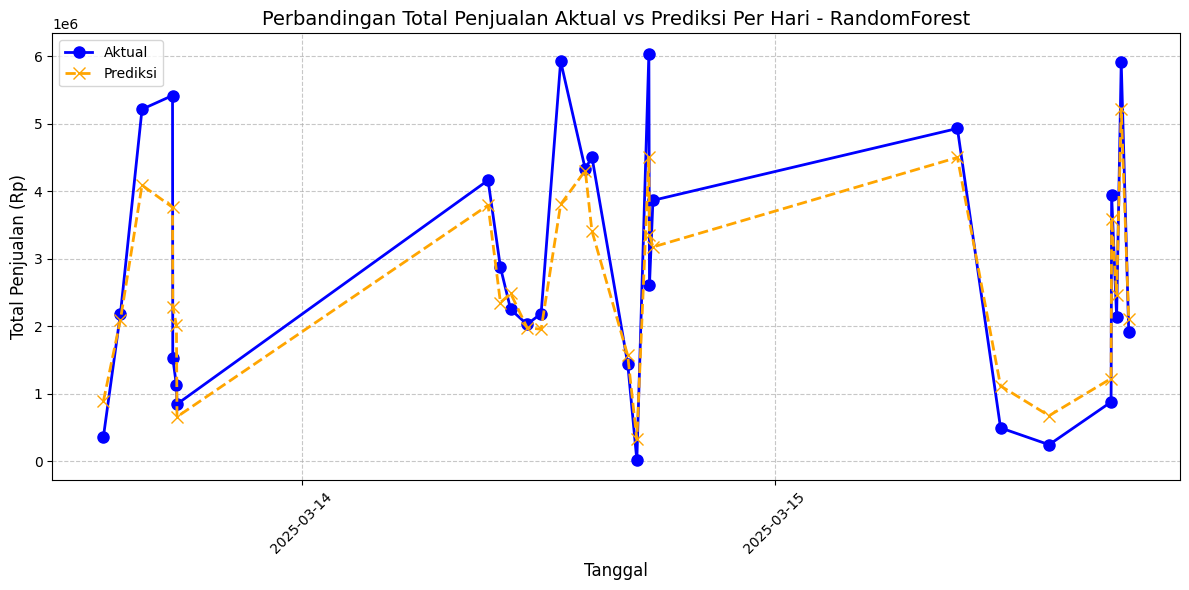

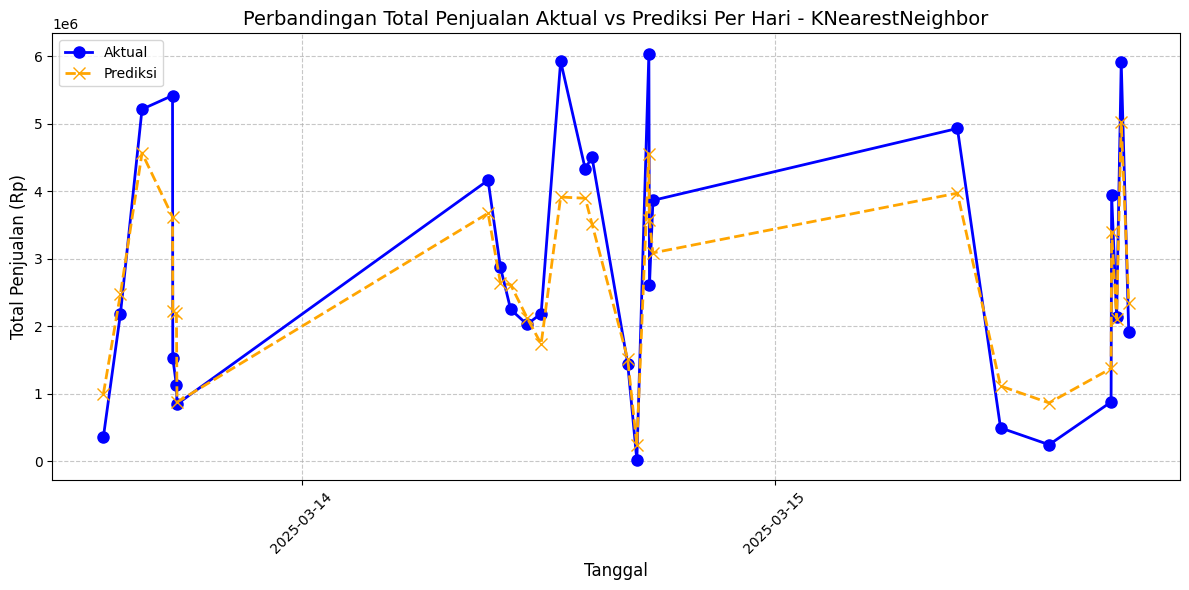

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


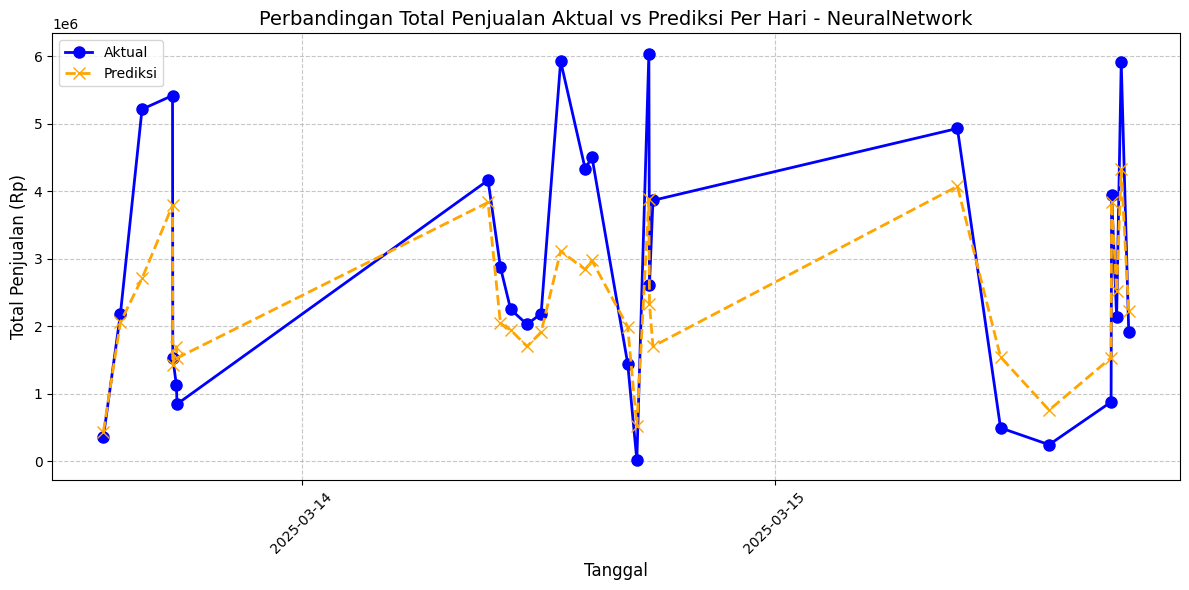

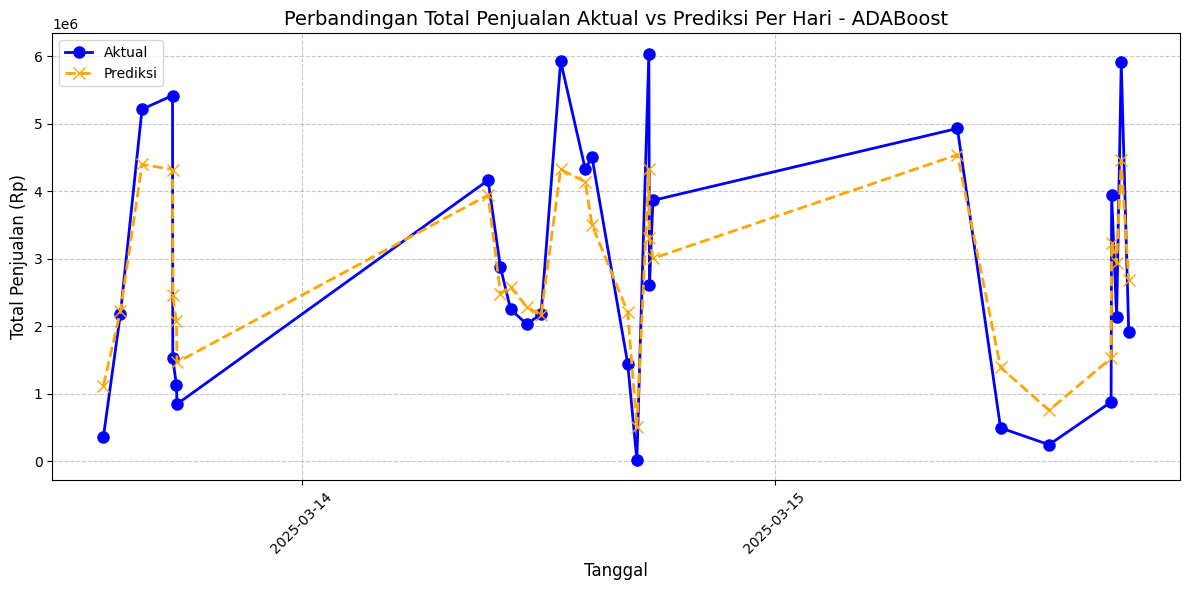

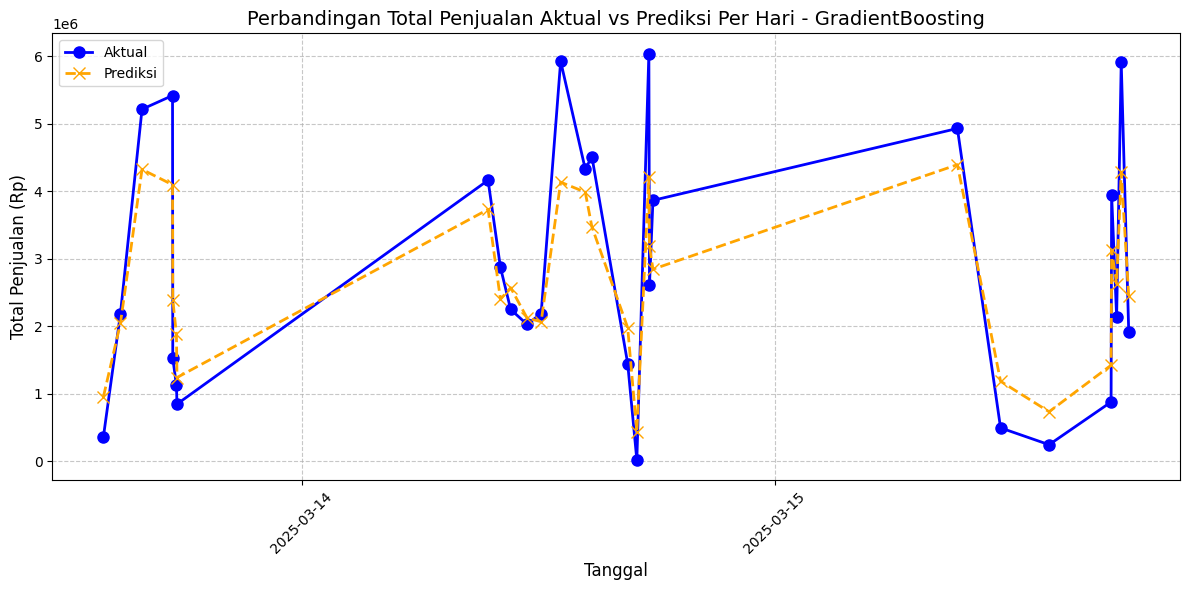


Hasil Evaluasi Model:
          LinearRegression  DecisionTree  ...      ADABoost  GradientBoosting
MAE           2.632106e+05  3.733725e+05  ...  2.674484e+05      2.627534e+05
MSE           1.050007e+11  2.189335e+11  ...  1.077444e+11      1.044700e+11
R2-Score      2.113533e-01 -6.443809e-01  ...  1.907458e-01      2.153398e-01

[3 rows x 7 columns]


In [218]:
import matplotlib.dates as mdates

models = {
    'LinearRegression': LinearRegression(),
    'DecisionTree': DecisionTreeRegressor(),
    'RandomForest': RandomForestRegressor(),
    'KNearestNeighbor': KNeighborsRegressor(),
    'NeuralNetwork': MLPRegressor(),
    'ADABoost': AdaBoostRegressor(),
    'GradientBoosting': GradientBoostingRegressor()
}

result = {}

# Setelah melatih model dan mendapatkan prediksi
for name, model in models.items():
    # Latih model
    model.fit(X_train, y_train)
    # Prediksi pada test set
    y_pred = model.predict(X_test)

    # Simpan metrik evaluasi
    result[name] = {
        'MAE': mean_absolute_error(y_test, y_pred),
        'MSE': mean_squared_error(y_test, y_pred),
        'R2-Score': r2_score(y_test, y_pred)
    }

    # Agregasi total penjualan aktual per hari
    actual_daily = test_df.groupby('transactionDate')['totalAmount'].sum().reset_index()
    actual_daily.columns = ['Tanggal', 'Total Penjualan Aktual']

    # Agregasi total penjualan prediksi per hari
    temp_df = test_df[['transactionDate']].copy()
    temp_df['pred_amount'] = y_pred
    predicted_daily = temp_df.groupby('transactionDate')['pred_amount'].sum().reset_index()
    predicted_daily.columns = ['Tanggal', 'Total Penjualan Prediksi']


    # Gabungkan data aktual dan prediksi
    daily_comparison = pd.merge(actual_daily, predicted_daily, on='Tanggal', how='left')

    daily_comparison = daily_comparison.sort_values('Tanggal')
    daily_comparison = daily_comparison.tail(28)

    # Visualisasi perbandingan aktual vs prediksi per hari
    plt.figure(figsize=(12, 6))
    plt.plot(daily_comparison['Tanggal'], daily_comparison['Total Penjualan Aktual'],
             marker='o', markersize=8, linestyle='-', linewidth=2, color='blue', label='Aktual')
    plt.plot(daily_comparison['Tanggal'], daily_comparison['Total Penjualan Prediksi'],
             marker='x', markersize=8, linestyle='--', linewidth=2, color='orange', label='Prediksi')

    # Judul dan label
    plt.title(f'Perbandingan Total Penjualan Aktual vs Prediksi Per Hari - {name}', fontsize=14)
    plt.xlabel('Tanggal', fontsize=12)
    plt.ylabel('Total Penjualan (Rp)', fontsize=12)

    # Format sumbu x untuk tanggal
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))  # Tampilkan setiap hari
    plt.xticks(rotation=45)

    # Tambahkan grid dan legenda
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()

    # Sesuaikan layout
    plt.tight_layout()
    plt.show()

# Tampilkan hasil evaluasi
print("\nHasil Evaluasi Model:")
print(pd.DataFrame(result))

In [219]:
pd.DataFrame(result)

,LinearRegression,DecisionTree,RandomForest,KNearestNeighbor,NeuralNetwork,ADABoost,GradientBoosting
MAE,2.632106e+05,3.733725e+05,2.798967e+05,2.812054e+05,3.277940e+05,2.674484e+05,2.627534e+05
MSE,1.050007e+11,2.189335e+11,1.189570e+11,1.228844e+11,1.646839e+11,1.077444e+11,1.044700e+11
R2-Score,2.113533e-01,-6.443809e-01,1.065296e-01,7.703130e-02,-2.369194e-01,1.907458e-01,2.153398e-01


In [ ]:
gbr = GradientBoostingRegressor()

param_grid = {
    'n_estimators': [1, 2, 4, 8, 16, 32, 64, 100, 200],
    'learning_rate': [1, 0.5, 0.25, 0.1, 0.05, 0.01],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 1.0],
    'min_samples_split': [2, 5]
}

grid_search = GridSearchCV(estimator=gbr, param_grid=param_grid,
                           scoring='neg_mean_squared_error', cv=5, n_jobs=-1, verbose=1)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
best_gb = grid_search.best_estimator_

y_pred = best_gb.predict(X_test)
print("MAE:", mean_absolute_error(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))
print("R2-Score:", r2_score(y_test, y_pred))


Fitting 5 folds for each of 648 candidates, totalling 3240 fits


In [134]:
ab_param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.5, 1.0],
    'loss': ['linear', 'square', 'exponential'],
    'estimator': [DecisionTreeRegressor(max_depth=1), DecisionTreeRegressor(max_depth=2)]
}

# Initialize AdaBoost
adaboost = AdaBoostRegressor(random_state=42)

# Perform Grid Search
grid_search = GridSearchCV(adaboost, ab_param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best parameters and model
print("Best Parameters:", grid_search.best_params_)
best_adaboost = grid_search.best_estimator_

# Evaluate
y_pred = best_adaboost.predict(X_test)
print("MAE:", mean_absolute_error(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))
print("R2-Score:", r2_score(y_test, y_pred))

Best Parameters: {'estimator': DecisionTreeRegressor(max_depth=2), 'learning_rate': 0.01, 'loss': 'linear', 'n_estimators': 200}
MAE: 425397.7815951469
MSE: 299918842743.8617
R2-Score: 0.284918002738625


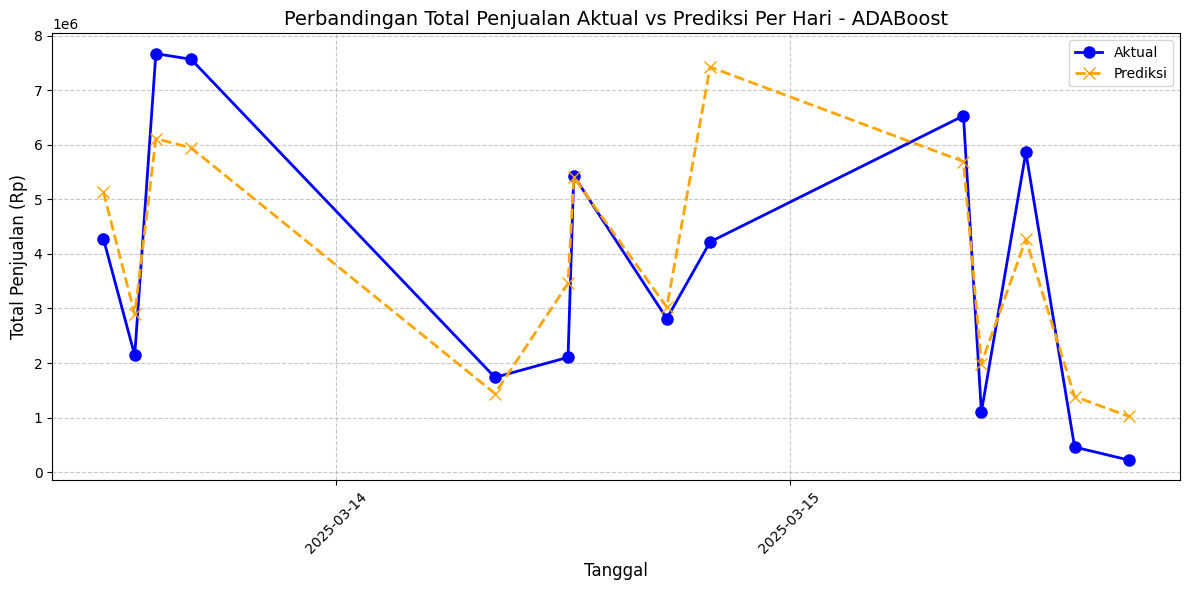

In [135]:
# Agregasi total penjualan aktual per hari
actual_daily = test_df.groupby('transactionDate')['totalAmount'].sum().reset_index()
actual_daily.columns = ['Tanggal', 'Total Penjualan Aktual']

# Agregasi total penjualan prediksi per hari
temp_df = test_df[['transactionDate']].copy()
temp_df['pred_tuning_amount'] = y_pred
predicted_daily = temp_df.groupby('transactionDate')['pred_tuning_amount'].sum().reset_index()
predicted_daily.columns = ['Tanggal', 'Total Penjualan Prediksi']

# Gabungkan data aktual dan prediksi
daily_comparison = pd.merge(actual_daily, predicted_daily, on='Tanggal', how='left')

# Batasi data untuk 14 hari terakhir agar pola lebih jelas
daily_comparison = daily_comparison.sort_values('Tanggal')
daily_comparison = daily_comparison.tail(14)  # Ambil 14 hari terakhir

# Visualisasi perbandingan aktual vs prediksi per hari
plt.figure(figsize=(12, 6))
plt.plot(daily_comparison['Tanggal'], daily_comparison['Total Penjualan Aktual'],
          marker='o', markersize=8, linestyle='-', linewidth=2, color='blue', label='Aktual')
plt.plot(daily_comparison['Tanggal'], daily_comparison['Total Penjualan Prediksi'],
          marker='x', markersize=8, linestyle='--', linewidth=2, color='orange', label='Prediksi')

# Judul dan label
plt.title(f'Perbandingan Total Penjualan Aktual vs Prediksi Per Hari - {name}', fontsize=14)
plt.xlabel('Tanggal', fontsize=12)
plt.ylabel('Total Penjualan (Rp)', fontsize=12)

# Format sumbu x untuk tanggal
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))  # Tampilkan setiap hari
plt.xticks(rotation=45)

# Tambahkan grid dan legenda
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

# Sesuaikan layout
plt.tight_layout()
plt.show()

In [ ]:
rf_param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf_model = RandomForestRegressor()

rf_grid_search = GridSearchCV(estimator=rf_model, param_grid=rf_param_grid,
                              cv=5, scoring='neg_mean_squared_error', n_jobs=-1,
                              verbose=1)

rf_grid_search.fit(X_train, y_train)

print("RandomForest - Parameter Terbaik:", rf_grid_search.best_params_)
print("RandomForest - Skor Terbaik (neg MSE):", rf_grid_search.best_score_)

# Evaluasi model terbaik pada test set
rf_best = rf_grid_search.best_estimator_
y_pred_rf = rf_best.predict(X_test)
print("RandomForest - MAE:", mean_absolute_error(y_test, y_pred_rf))
print("RandomForest - MSE:", mean_squared_error(y_test, y_pred_rf))
print("RandomForest - R2-Score:", r2_score(y_test, y_pred_rf))

Fitting 5 folds for each of 48 candidates, totalling 240 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


RandomForest - Parameter Terbaik: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
RandomForest - Skor Terbaik (neg MSE): -276080349030.2529
RandomForest - MAE: 407861.4962777243
RandomForest - MSE: 276800182584.3302
RandomForest - R2-Score: 0.34003870649181744


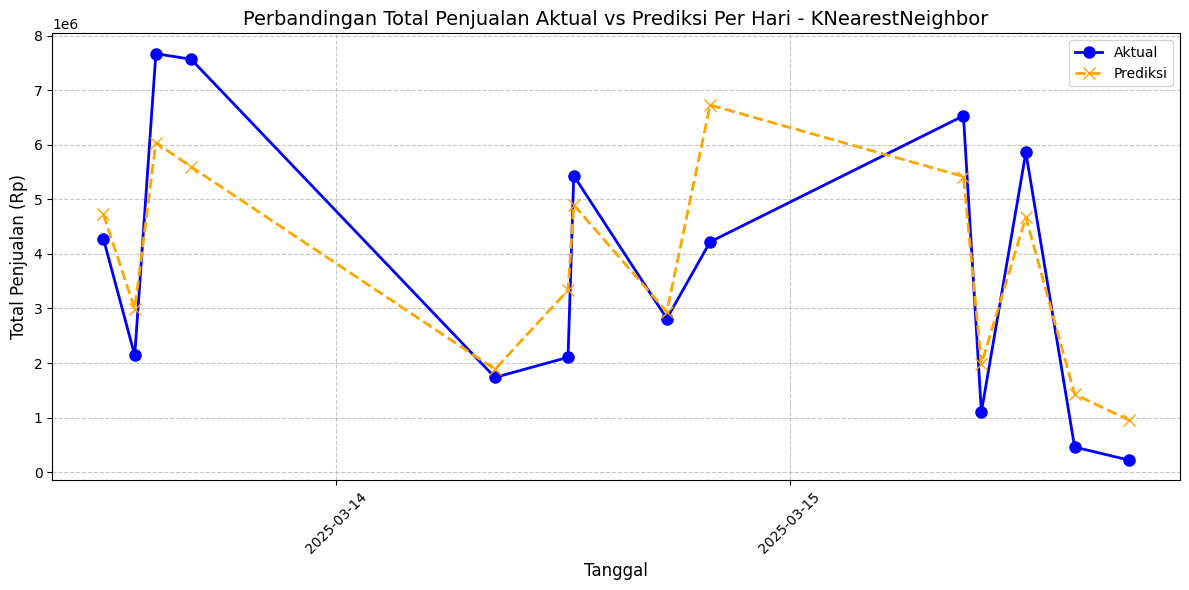

In [ ]:
# Agregasi total penjualan aktual per hari
actual_daily = test_df.groupby('transactionDate')['totalAmount'].sum().reset_index()
actual_daily.columns = ['Tanggal', 'Total Penjualan Aktual']

# Agregasi total penjualan prediksi per hari
temp_df = test_df[['transactionDate']].copy()
temp_df['pred_tuning_amount'] = y_pred_rf
predicted_daily = temp_df.groupby('transactionDate')['pred_tuning_amount'].sum().reset_index()
predicted_daily.columns = ['Tanggal', 'Total Penjualan Prediksi']

# Gabungkan data aktual dan prediksi
daily_comparison = pd.merge(actual_daily, predicted_daily, on='Tanggal', how='left')

# Batasi data untuk 14 hari terakhir agar pola lebih jelas
daily_comparison = daily_comparison.sort_values('Tanggal')
daily_comparison = daily_comparison.tail(14)  # Ambil 14 hari terakhir

# Visualisasi perbandingan aktual vs prediksi per hari
plt.figure(figsize=(12, 6))
plt.plot(daily_comparison['Tanggal'], daily_comparison['Total Penjualan Aktual'],
          marker='o', markersize=8, linestyle='-', linewidth=2, color='blue', label='Aktual')
plt.plot(daily_comparison['Tanggal'], daily_comparison['Total Penjualan Prediksi'],
          marker='x', markersize=8, linestyle='--', linewidth=2, color='orange', label='Prediksi')

# Judul dan label
plt.title(f'Perbandingan Total Penjualan Aktual vs Prediksi Per Hari - {name}', fontsize=14)
plt.xlabel('Tanggal', fontsize=12)
plt.ylabel('Total Penjualan (Rp)', fontsize=12)

# Format sumbu x untuk tanggal
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))  # Tampilkan setiap hari
plt.xticks(rotation=45)

# Tambahkan grid dan legenda
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

# Sesuaikan layout
plt.tight_layout()
plt.show()